In [1]:
import scipy.integrate as integrate
import scipy.special as special
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import PyMieScatt as pm

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.special import jv, yv
from scipy.stats import qmc
import warnings
from scipy.integrate import quad_vec
import functools

#This function is used to calculate the Mie coefficients a_n and b_n.
#For reference, see the book Bohren & Huffman. The basic solution is given
#in equation (4.53). The version implemented here is from equations
#(4.56) and (4.57), which assume the permeability of particle and
#surrounding medium to be the same!! This is an ASSUMPTION.

#To compute the coefficients we use the equations given in section
#4.8 of the book.

#Inputs: m is the (complex) refractive index of the particle, x is the
#size parameter calculated as 2 * pi * n * r / lambda, and n is the
#refractive index of the medium (assumed to be 1 by default here), r
#is the particle size (radius) and lambda the wavelength of the incoming light
def MieCoefficients_ab(m,x,c=1,mediumindex=1):

  #for x correctly
  x = x* mediumindex.real
  m = m/ mediumindex.real
  mx = m*x

  #A good rule of thumb is that we need about x (size parameter) terms for
  #the sum to give good reslts (start of section 4.8 in Bohren and Huffman)
  #so we set the max sum index to the expression below.
  #c is 1 per default but can be changed in the function input increase
  #the upper bound of the summation.
  nmax = np.amax(np.round(c*(2+x+4*(x**(1/3)))))
  mxmax = np.amax(np.round(np.abs(mx)))

  #this will be used as the max index for the calculation of the
  #D_n below, given in eq. (4.89). The +16 terms are used for initialization
  #and will be dropped later. (see calculation of Dn below)

  nmax_Dn = np.round(max(nmax,mxmax)+16)

  #this will give us the index for the bessel/hankel/etc. functions
  n = np.arange(1,nmax+1) #
  nu = n + 0.5 #
  nu = nu[np.newaxis]
  n = n[np.newaxis]
  #this is the prefactor used to convert the normal bessel functions into
  #the so called Riccati Bessel functions. These are defined in Bohren and
  #Huffman right above equation (4.56)
  prefactor = np.sqrt(0.5*np.pi*x)

  #Here we define the Ricatti functions. The second line is needed because
  #we start at n=1 but we need to add the zeroth function, which is sin(x) for
  #the Ricatti function dubbed Sn and cos(x) for Cn. This effectively shifts
  #the index by 1, which is exactly what we need for the formula (4.88) in
  #the book
  RicattiSn = prefactor*jv(nu.T,x) #
  RicattiSn0 = np.insert(RicattiSn, 0, np.sin(x), 0)
  RicattiSn0 = np.delete(RicattiSn0, -1, 0) #

  RicattiCn = -prefactor*yv(nu.T,x) #
  RicattiCn0 = np.insert(RicattiCn, 0, np.cos(x), 0)
  #RicattiCn0 = np.append(np.cos(x), RicattiCn[0:int(nmax)-1]) #
  RicattiCn0 = np.delete(RicattiCn0, -1, 0)

  RicattiXin = RicattiSn-(0+1j)*RicattiCn #
  RicattiXin0 = RicattiSn0-(0+1j)*RicattiCn0 #

  #Here we add an axis to be able to do the .T command later, where we want to
  #subtract for example the first element from all the columns in the first row.
  #this is done by subtracting a row-vector from the matrix

  #here we define Dn, which is a quantity also needed to calculate the
  #coefficients in (4.88), and the definition of Dn is given in (4.89).
  #each term in the recurrence relation reduces the error signigicantly,
  #which is why here I initiate with zero and calculate more terms then
  #necessary and in the end throw away the first few terms.
  D_n = np.zeros((int(nmax_Dn),len(m)),dtype=complex)
  for i in range(int(nmax_Dn)-1,1,-1):
    D_n[i-1,:] = (i/mx)-(1/(D_n[i,:]+i/mx))


  #Here we drop the terms beyond nmax that we needed to initialize and we
  #start at index 1 because there is no a0 but we start with n=1.
  D_n = D_n[1:int(nmax)+1,:]

  #Here I just define the two factors in brackets from eq. (4.88)
  #Python is amazing here because the array-matrix multiplication does
  #exactly what we want here. multiplying an array with a matrix,
  #the rows are multiplied elementwise with the array and this happens for
  #every row, which is exactly what we want.
  FactorFora_n = D_n/m + n.T/x
  FactorForb_n = m*D_n + n.T/x

  #Now, finally, calculating the coefficients according to eq. (4.88) :D
  a_n = (FactorFora_n*RicattiSn - RicattiSn0) / (FactorFora_n*RicattiXin-RicattiXin0)
  b_n = (FactorForb_n*RicattiSn - RicattiSn0) / (FactorForb_n*RicattiXin-RicattiXin0)

  return a_n, b_n



#Here I define a function which is used to calculate the same coefficients as before
#but with the simplifying assumption that we have small particles (compared to the wavelength)
#which means we can approximate the whole thing by just the first few terms.
#This is done in section 5.1 in Bohren and Huffman.
def LowFrequencyMieCoefficients_ab(m,x,mediumindex=1):

  x = x* mediumindex.real
  m = m/ mediumindex.real

  a_1 = (-2j/3) * x**3 * (m**2-1)/(m**2+2)  -  (2j/5) * x**5  * (m**2-1)*(m**2-2)/(m**2+2)**2  +  (4/9) * x**6 * ((m**2-1)/(m**2+2))**2

  b_1 = (-1j/45) * x**5 * (m**2-1)

  a_2 = (-1j/15) * x**5 * (m**2-1)/(2*m**2+3)

  b_2 = 0+0j

  a_n = np.vstack((a_1,a_2))
  b_n = np.vstack((b_1,b_2))
  return a_n , b_n

#This function automatically decides to use the low-frequency approximation if the
#size parameter is smaller than limit, which is set to 0.5 by default. There is
#also an option to switch auto to False, in which case only the full treatment is
#used and no low frequency approximation is used even for small particles.
def AutomaticMieCoefficients_ab(m,x,c=1,mediumindex=1,limit=0.5,auto=True):
    minimum = np.amin(np.abs(x))
    if auto:
        if minimum<limit:
          return LowFrequencyMieCoefficients_ab(m,x,mediumindex)
        else:
          return MieCoefficients_ab(m,x,c,mediumindex)
    else:
        return MieCoefficients_ab(m,x,c,mediumindex)


#Here the angle-dependent functions pi_n and tau_n are calculated
#via a recursion relation as shown in equation (4.47)
def PiTau(angle,nmax):

  mu = np.cos(angle/180*np.pi)

  #This creates a 2D array with zeroes where the columns are the angles
  #(which is why there are 180 columns) and the rows are the pi_n and tau_n
  #for every angle
  pi = np.zeros((int(nmax),len(angle)))
  tau = np.zeros((int(nmax),len(angle)))

  #Here I calculate the first two elements according to relation (4.47) in
  #the book. Caveat!: the zeroth index is actually the element pi_1, tau_1.
  #this is because in the sum we start with n=1 so we don't consider n=0,
  #but it is nevertheless used to calculate n=1 via the relation (4.47)
  pi[0,:] = 1
  pi[1,:] = 3*mu

  tau[0,:] = mu
  #tau[1,:] = 3*(2*mu**2-1)
  tau[1,:] = 3.0*np.cos(2*np.arccos(mu))

  #After initializing the first few elements, now the rest is calculated
  #with the aforementioned recurrence relation
  #Caveat!: the element at index n=0 is actually the term for n=1. so
  #when calculating pi_n, we need to replace n in (4.47) by n+1, because
  #our index lags one behind (index 0 is actually for n=1, etc.)
  for n in range(2,int(nmax)):
    pi[n,:] = (2*n+1)/n * (mu*pi[n-1,:]) - (n+1)/n * pi[n-2,:]
    tau[n,:] = (n+1)*mu * pi[n,:] - (n+2) * pi[n-1,:]
  return pi, tau


#Here the Matrix Elements of the Scattering (2x2) matrix are calculated.
#The formulas for these matrix elements are given in equation (4.74)
#from these formulas we can then calculate the phase functions in the
#mueller matrix
def ScatteringMatrixElements(m,x,angle,c=1,n=1,limit=0.5,auto=True):

  xmax = np.amax(x)
  nmax = np.round(c*(2+xmax+4*np.power(xmax,1/3)))

  #determine the coefficients used to calculate the matrix elements S1 and S2
  #see function description for MieCoefficients_ab above
  a_n, b_n = MieCoefficients_ab(m,x,c,n)
  a_n = a_n[:,np.newaxis,:]
  b_n = b_n[:,np.newaxis,:]

  #Calculate the functions pi and tau needed for the calculation.
  #see function description for PieTau above
  pi_n, tau_n = PiTau(angle,nmax)

  #This gives the matrix a new (3rd) axis. This is needed because we multiply
  #with the a_n and b_n later. why? --> we have two matrices: the pi/tau_n
  #which are all the n's for every angle, and the an/bn, which are all the
  #n's for every refractive index. we now need to multiply the first entry
  #of the pi_n matrix (=pi_1 for angle theta=1) with the entire first row
  #of the index vs. an matrix in order to get pi_1*a_1 at angle theta = 1
  #for every refractive index in the matrix. So every angle gives an entirely
  #new matrix and in the end we have a rank 3 tensor.
  #when we then sum over one axis of this rank 3 tensor, we are left with
  #a rank 2 tensor (=matrix) whose elements then are the ScatteringMatrixElements
  #for each refractive index and each angle. The rows will be the angles
  #and the columns will be the different refractive indices
  pi_n = pi_n[:,:,np.newaxis]
  tau_n = tau_n[:,:,np.newaxis]

  #Here I create an array for the summation in formula (4.74)
  #remember that for all our quantities, the zero-index value is actually
  #the n=1 value. So here an array is created with numeric value 1 in its
  #first entry (= zeroth index) in order to sum properly according to formula (4.74)
  n = np.arange(1,int(nmax)+1)

  #this is the prefactor in the sum (4.74) and needs to be transposed with
  #the nexaxis command in order to multiply the correct entries in the rank 3
  #tensor below
  Prefactor = (2*n+1)/(n*(n+1))
  Prefactor = Prefactor[np.newaxis,np.newaxis]
  Prefactor = Prefactor.T

  #a_n is a matrix with the columns being different refractive indices and the
  #rows being the a_n for these indices, so I need the number or rows to know
  #how many a_n there are, to know until what n to sum.
  UpperSumIndex_a = np.shape(a_n)[0]
  UpperSumIndex_b = np.shape(b_n)[0]

  #finally, actual calculation of the sum (4.74) to get the matrix elements S1 and S2 ;)
  S_1 = np.sum(Prefactor[0:UpperSumIndex_a] * ( pi_n[0:UpperSumIndex_a,:] * a_n + tau_n[0:UpperSumIndex_b,:] * b_n),0)
  S_2 = np.sum(Prefactor[0:UpperSumIndex_a] * (tau_n[0:UpperSumIndex_a,:] * a_n + pi_n[0:UpperSumIndex_b,:] * b_n),0)

  #The returned matrices will have the S-values as entries. Since S depends on the angle and the
  #refractive index, we have "two dimensions". The columns will correspond to different refractive
  #indices and the rows will correspond to different angles. so the entry M_57 in the matrix
  #will be the S-element for the angle of 5 degrees of the 7th refractive index in the data set
  return S_1, S_2


#Here we use equation(s) (4.77) in the book to get the two elements we want
#we want S11 and -S12/S11, which is the polarized phase function
#the radius and the wavelength have to be input with the same units. so if one
#used nanometers for the wavelength, the particle radius needs to be nanometers as well.
def PhaseFunctions(m,wavelength,radius,angle,mediumindex=1.0,limit=0.5,auto=True,c=1):

  #n = n.real
  wavelength = wavelength/mediumindex.real
  x = 2*np.pi*radius/wavelength

  S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

  S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
  S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

  #PPF: polarized phase function
  PPF = -S_12/S_11

  return S_11, PPF



#This function integrates over a particle size distribution
#def sizedistribution(r, Vtot, sigma, rmean):
 #   return Vtot/(np.sqrt(2*np.pi)) * 1/sigma * 1/r * np.exp(-(np.log(r)-np.log(rmean))**2/(2*sigma**2))

#This creates a matrix where every row is a new set of parameters and every column consists of different values for the
#same parameter. It uses LatinHypercube sampling, meaning (roughly) it chooses random values from a n-dimensional cube with
#specific size-bounds that can be set in the input
def CreateParameterMatrix(SampleSize, RealIndexBounds, ImaginaryIndexBounds, SigmaBounds, MeanRadiusBounds, VolumeConcentrationBounds):

    #This creates a matrix with random entries which has 5 columns (=number of parameters we want)
    #and as many rows as we want to, which will correspond to the samplesize we choose
    sampler = qmc.LatinHypercube(d=5)
    sample = sampler.random(n=SampleSize)

    #This creates the lower and upper bounds for the parameters which are also taken as input values
    LowerBounds = np.array([RealIndexBounds[0], ImaginaryIndexBounds[0], SigmaBounds[0], MeanRadiusBounds[0], VolumeConcentrationBounds[0]])
    UpperBounds = np.array([RealIndexBounds[1], ImaginaryIndexBounds[1], SigmaBounds[1], MeanRadiusBounds[1], VolumeConcentrationBounds[1]])

    #This rescales all the created random values in the matrix to match the lower and upper bounds that we set
    sample = qmc.scale(sample, LowerBounds, UpperBounds)

    #This makes a pandas dataframe out of the sample matrix
    Data = pd.DataFrame(sample, columns=['RealRefractiveIndex', 'ImaginaryRefractiveIndex', 'Sigma', 'MeanRadius', 'VolumeConcentration'])

    return Data


def SinglePhaseFunctionsFromParameterSet(ParameterSet, wavelength, mediumindex=1.0, limit=0.5, auto=True, c=1):

    RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
    RelativeIndex = RefractiveIndex/mediumindex

    Radius = ParameterSet['MeanRadius'].to_numpy()

    Angles = np.arange(1,180)

    S_11, PPF = PhaseFunctions(RelativeIndex,wavelength,Radius,Angles,mediumindex=mediumindex,limit=limit,auto=auto,c=c)

    return S_11, PPF


def sizedistribution(r, Vtot, sigma, rmean):
    return Vtot/(np.sqrt(2*np.pi)) * 1/np.log(sigma) * 1/(np.pi * r**2) * np.pi * 1/r * 1/(2*np.pi*r/532)**2 * np.exp(-(np.log(r)-np.log(rmean))**2/(2*np.log(sigma)**2))

def integrand(radius, m, wavelength, mediumindex, angle, Vtot, sigma, rmean, c, limit, auto):

            wavelength = wavelength/mediumindex.real
            x = 2*np.pi*radius/wavelength

            S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

            S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
            S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

            #PPF: polarized phase function
            PPF = -S_12/S_11

            return (S_11*sizedistribution(radius, Vtot, sigma, rmean))
    
def EnsemblePhaseFunctions(m, wavelength, Vtot, sigma, rmean, radiusbounds = np.array([150,800]),angle=np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

    PartialIntegrand = functools.partial(integrand, m=m, wavelength=wavelength, mediumindex=mediumindex, angle=angle, Vtot=Vtot, sigma=sigma, rmean=rmean, c=c, limit=limit, auto=auto)

    IntegratedMatrix = quad_vec(PartialIntegrand,radiusbounds[0],radiusbounds[1],workers=-1, epsrel=1e-25)

    return IntegratedMatrix

def IntegratedEnsembleMatrixFromParameterSet(ParameterSet, wavelength, radiusbounds = np.array([10,5000]), angles = np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

        RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
        RelativeIndex = RefractiveIndex/mediumindex
        Vtot = ParameterSet['VolumeConcentration'].to_numpy()
        sigma = ParameterSet['Sigma'].to_numpy()
        rmean = ParameterSet['MeanRadius'].to_numpy()

        IntegratedMatrix = EnsemblePhaseFunctions(RelativeIndex, wavelength, Vtot, sigma, rmean, radiusbounds=radiusbounds, angle=angles, mediumindex=mediumindex, limit=limit, auto=auto, c=c)

        return IntegratedMatrix
    
    
    
    


# Create Dataset with own Library

In [3]:
Parameters = CreateParameterMatrix(5, [1.0,1.7], [0,0.1], [1.3,1.5], [100,1000], [30,2000])
print(Parameters)
S_11, PPF = SinglePhaseFunctionsFromParameterSet(Parameters, 532)
np.shape(S_11)

   RealRefractiveIndex  ImaginaryRefractiveIndex     Sigma  MeanRadius  \
0             1.500492                  0.023298  1.416898  233.076190   
1             1.331826                  0.076942  1.354745  501.728523   
2             1.143963                  0.017309  1.477355  774.905152   
3             1.052059                  0.090448  1.450074  360.482995   
4             1.619483                  0.045151  1.318208  890.434443   

   VolumeConcentration  
0          1134.361512  
1           496.028373  
2          1248.757286  
3          1708.776239  
4           182.591438  


(179, 5)

In [4]:
wavelength = 532

%time IntegratedMatrix = IntegratedEnsembleMatrixFromParameterSet(Parameters, wavelength)


IntegratedMatrix

CPU times: user 236 ms, sys: 874 ms, total: 1.11 s
Wall time: 12.3 s


(array([[1.19047240e-01, 3.74303254e-02, 7.96810990e-02, 1.50252730e-02,
         9.39223029e-03],
        [1.18694890e-01, 3.70269601e-02, 7.74311855e-02, 1.49131360e-02,
         9.07680385e-03],
        [1.18110703e-01, 3.63663974e-02, 7.38810675e-02, 1.47288492e-02,
         8.57695299e-03],
        [1.17299220e-01, 3.54655706e-02, 6.92920621e-02, 1.44761914e-02,
         7.92781922e-03],
        [1.16266694e-01, 3.43469707e-02, 6.39668527e-02, 1.41601990e-02,
         7.17208454e-03],
        [1.15020985e-01, 3.30375552e-02, 5.82100129e-02, 1.37869404e-02,
         6.35503940e-03],
        [1.13571436e-01, 3.15675035e-02, 5.22977782e-02, 1.33632616e-02,
         5.51999281e-03],
        [1.11928730e-01, 2.99689110e-02, 4.64596356e-02, 1.28965206e-02,
         4.70465841e-03],
        [1.10104718e-01, 2.82745087e-02, 4.08708243e-02, 1.23943287e-02,
         3.93885226e-03],
        [1.08112255e-01, 2.65164820e-02, 3.56530932e-02, 1.18643128e-02,
         3.24353945e-03],
        [1

In [7]:
angle=np.arange(1,181)
plt.figure()
for i in range(5):
    plt.plot(angle,np.log(IntegratedMatrix[0][:,i]/max(IntegratedMatrix[0][:,i])))
plt.xlabel('Angle theta')
plt.ylabel('log(P_11)')

Text(0, 0.5, 'log(P_11)')

# Compare Data with PyMieScatt

The function we want here is MatrixElements(m, wavelength, diameter, mu) which returns S11, S12, S33, S34. mu is the cosine of the angle.

In [64]:
entry = 2

angles1 = np.arange(179)
anglesradian = angles * np.pi / 180
mu = np.cos(anglesradian)
diameter = 2*Parameters['MeanRadius'][entry]

wavelength = 532

i = complex(0,1)
m = Parameters['RealRefractiveIndex'][entry] + Parameters['ImaginaryRefractiveIndex'][entry]*i

S11 = np.zeros(179)

for i in range(179):
    S11[i] = pm.MatrixElements(m,wavelength,diameter,np.cos(i*np.pi/180))[0]

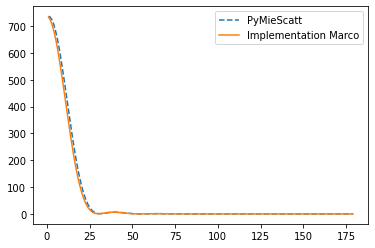

In [66]:
plt.figure()
plt.plot(angles, S11, '--', label='PyMieScatt')
plt.plot(angles, S_11[:,entry], label='Implementation Marco')
plt.legend()

# Comparison with GRASP OPEN Data

In [4]:
Parameters = pd.read_csv('/data/user/ponts_m/aerosol/aerosol_data/raw_data/GRASP_LHS_rand_paremeters.csv')

PhaseFunctionsData = pd.read_csv('/data/user/ponts_m/aerosol/aerosol_data/raw_data/ML_simulated_scat_data.csv')

In [5]:
PhaseFunctionsData

P11_0.450_0   P11_0.450_1   P11_0.450_2   P11_0.450_3   P11_0.450_4  \
0      6.368800e-07  6.109700e-07  5.412900e-07  4.469300e-07  3.479400e-07   
1      3.997100e-07  3.686800e-07  2.938300e-07  2.093700e-07  1.381200e-07   
2      1.022200e-07  1.005900e-07  9.592600e-08  8.881100e-08  8.004000e-08   
3      9.708000e-07  9.124000e-07  7.647400e-07  5.844500e-07  4.173200e-07   
4      5.633700e-07  5.041600e-07  3.717800e-07  2.393800e-07  1.420400e-07   
...             ...           ...           ...           ...           ...   
99995  1.041800e-06  9.019600e-07  6.084900e-07  3.458400e-07  1.782700e-07   
99996  8.485600e-08  7.980900e-08  6.688300e-08  5.084500e-08  3.582100e-08   
99997  7.346600e-07  6.577500e-07  4.852300e-07  3.120300e-07  1.844100e-07   
99998  9.438100e-07  9.075800e-07  8.096000e-07  6.755000e-07  5.328700e-07   
99999  6.972400e-07  6.242900e-07  4.587900e-07  2.911400e-07  1.679700e-07   

        P11_0.450_5   P11_0.450_6   P11_0.450_7   P11_0.450_8   P11_0.450_9  \
0      2.584800e-07  1.852800e-07  1.294800e-07  8.905900e-08  6.087000e-08   
1      8.684400e-08  5.331200e-08  3.260900e-08  2.025000e-08  1.296000e-08   
2      7.043500e-08  6.071900e-08  5.143900e-08  4.295400e-08  3.545800e-08   
3      2.844200e-07  1.883600e-07  1.230800e-07  8.042200e-08  5.319300e-08   
4      8.111000e-08  4.625200e-08  2.718100e-08  1.693100e-08  1.132000e-08   
...             ...           ...           ...           ...           ...   
99995  8.875800e-08  4.533300e-08  2.491900e-08  1.526800e-08  1.026400e-08   
99996  2.387100e-08  1.533300e-08  9.664400e-09  6.081800e-09  3.889600e-09   
99997  1.044800e-07  5.880600e-08  3.387000e-08  2.051400e-08  1.321700e-08   
99998  4.018500e-07  2.927400e-07  2.080100e-07  1.454600e-07  1.009900e-07   
99999  9.213900e-08  5.009700e-08  2.803700e-08  1.673300e-08  1.078500e-08   

       ...  P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0      ...      -0.052747      -0.035190      -0.017400      -0.002096   
1      ...      -0.071542      -0.071420      -0.054486      -0.018508   
2      ...      -0.218350      -0.169500      -0.127950      -0.093591   
3      ...      -0.009081      -0.000272       0.005402       0.008272   
4      ...      -0.124020      -0.164020      -0.206960      -0.247820   
...    ...            ...            ...            ...            ...   
99995  ...      -0.229180      -0.218590      -0.191350      -0.143750   
99996  ...      -0.016720       0.000184       0.023791       0.049211   
99997  ...      -0.001231       0.001972       0.004347       0.005759   
99998  ...      -0.253780      -0.215750      -0.176840      -0.138900   
99999  ...      -0.015387      -0.033503      -0.051614      -0.064725   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.008360       0.012986       0.012547       0.009012   
1           0.032199       0.078827       0.094504       0.073671   
2          -0.065859      -0.043995      -0.027237      -0.014919   
3           0.008883       0.007896       0.005988       0.003786   
4          -0.275150      -0.272900      -0.230460      -0.156100   
...              ...            ...            ...            ...   
99995      -0.071882       0.022137       0.111770       0.140910   
99996       0.067518       0.070493       0.057884       0.037409   
99997       0.006170       0.005666       0.004475       0.002938   
99998      -0.103630      -0.072444      -0.046379      -0.026005   
99999      -0.066719      -0.054157      -0.032299      -0.013057   

       P12_0.630_178  P12_0.630_179  
0           0.004633       0.001252  
1           0.038134       0.010142  
2          -0.006503      -0.001607  
3           0.001817       0.000475  
4          -0.076788      -0.020044  
...              ...            ...  
99995       0.092563       0.027021  
99996       0.017834       0.004599  
99997       0.001452       0.000386  
99998      -

Getting all the parameters and converting them to numpy arrays

In [6]:
Vtot = Parameters['V_tot']
Rmedian = Parameters['R_median']
GSD = Parameters['GSD']
n450 = Parameters['n_450nm']
n532 = Parameters['n_532nm']
n630 = Parameters['n_630nm']
k450 = Parameters['k_450nm']
k532 = Parameters['k_532nm']
k630 = Parameters['k_630nm']

Vtotarray = Vtot.to_numpy()
Rmedianarray = Rmedian.to_numpy()
GSDarray = GSD.to_numpy()
n450array = n450.to_numpy()
n532array = n532.to_numpy()
n630array = n630.to_numpy()
k450array = k450.to_numpy()
k532array = k532.to_numpy()
k630array = k630.to_numpy()

Getting all the phase function data

In [7]:
#this gives the index of which parameter set to plot
index = 40
PhaseFunction1 = PhaseFunctionsData.loc[index,:].to_numpy()

#this gives the different phase functions for the selected parameter set
P11_450 = PhaseFunction1[0:179]
P11_532 = PhaseFunction1[180:359]
P11_630 = PhaseFunction1[360:539]
P12_450 = PhaseFunction1[540:719]
P12_532 = PhaseFunction1[720:899]
P12_630 = PhaseFunction1[900:1079]

In [44]:
Rmedian[40]

0.2848060329830695

Plotting some functions to check if everything worked

In [45]:
GSD[40]

1.4404363150219168

In [7]:
x = np.linspace(1,179,179)

plt.figure()
plt.plot(x,P11_450/max(P11_450))
plt.show()

Now we calculate this curve using the library above. This is done using the EnsemblePhaseFunctions() - Function whose imputs are

- relative refractive indes
- wavelengths in nm
- total volume concentration
- sigma
- mean radius in nm
- radius bounds (from where to where to integrate) --> also has a default value already
- other things which have a default value (check code above if interested)

In [159]:
RelativeIndex = np.array([complex(n450array[index], k450array[index])])
wavelength = 450
Vtot = Vtotarray[index]
sigma = GSDarray[index]
rmean = Rmedianarray[index]*1000

lowerbound = 50 #100
upperbound = 15000 #360
SimulatedFct = EnsemblePhaseFunctions(RelativeIndex, wavelength, Vtot, sigma, rmean, radiusbounds=[lowerbound,upperbound])

plot the results from the calculation together with the original GRASP OPEN Data

The results depend strongly!! on the integration bounds we consider. If the bounds are changed slightly the curve can shift significantly! So for every parameter set it's a bit of trial and error to get the correct integration bounds. This is mainly because I don't know what Grasp Open really does behind the scenes.

The mean radius for the index 40, 450 nm case is 284.8 nm and the integration bounds that work here are 100-360, so I guess you need to stay close to the mean radius to get a matching curve.

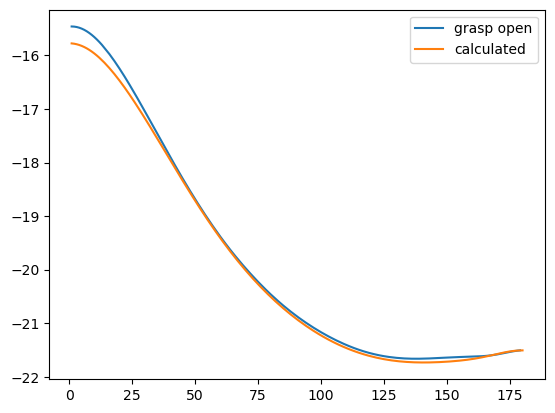

The integration bounds were  50  and  15000
The mean radius was  284.8060329830695 nm


In [188]:
x = np.linspace(1,179,179)
x1 = np.linspace(1,180,180)

plt.figure()
plt.plot(x,np.log(P11_450), label = 'grasp open')
plt.plot(x1,np.log(SimulatedFct[0]*10**(-6.3)), label = 'calculated')

y = np.delete(SimulatedFct[0], -1)

#plt.plot(x,y-P11_450, label='difference')
#plt.plot(x,y/P11_450, label='ratio')
plt.legend()
plt.show()

print('The integration bounds were ', lowerbound, ' and ', upperbound)
print('The mean radius was ', rmean, 'nm')

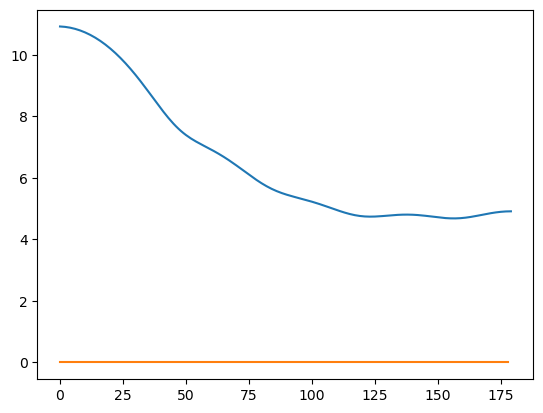

In [29]:
plt.plot(np.log(SimulatedFct[0]))
plt.plot(P11_450)
plt.show()

In [86]:
np.delete(np.array([1,2,3]),-1)

array([1, 2])

In [204]:
R=8.3144598
x=20

In [206]:
3*R*np.exp(1/x)/((x*(np.exp(1/x)-1)))**2/500

0.04987636702425532

In [207]:
57.317398/24.69

2.3214823005265286